In [2]:
#Imbalanced Classification Problem
#Import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from decimal import *
getcontext().prec = 17

In [3]:
dataset1 = pd.read_excel("/Users/antonio/GitHub/ia/data.xlsx")
dataset1.head()

ID_studente  Genere  Diploma_scuola_sup  AreaGeografica_scuola_sup  \
0            1       1                   1                          3   
1            2       1                   1                          4   
2            3       1                   1                          4   
3            4       1                   1                          4   
4            5       1                   1                          3   

   Voto_scuola_sup  Voto_scuola_sup_classi  Età_immatricolazione  \
0            100.0                       1                     1   
1            100.0                       1                     1   
2            100.0                       1                     1   
3            100.0                       1                     1   
4            100.0                       1                     1   

   Situazione_OFA  Corso_di_studio_IDAggr  Scuola  Ciclo  Abbandoni  
0               1                     446       4      2          0  
1               1                     446       4      2          0  
2               2                     446       4      2          0  
3               1                     446       4      2          0  
4               2                     446       4      2          0

In [8]:
#Clean dataset
dataset = dataset1.drop(columns = ["ID_studente", "Voto_scuola_sup"] )

#The ratio of 0s to 1s is 1:7. This is a clear case of Imbalances class classification
X = dataset.drop('Abbandoni', axis=1)
y = dataset['Abbandoni']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [9]:
#prima bisogna porre tutti i valori sulla stessa scala

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

/Users/antonio/anaconda2/envs/dropout/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/antonio/anaconda2/envs/dropout/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/antonio/anaconda2/envs/dropout/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """


## Matrice di covarianza

In [13]:
import numpy as np
cov_mat = np.cov(X_train_std.T)  #np.cov calco
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[1.86630467 1.57556784 1.14307987 0.96617729 0.56500187 0.65471446
 0.69035601 0.78779538 0.75188289]


In [14]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

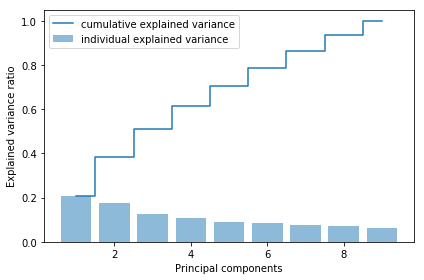

In [18]:
import matplotlib.pyplot as plt


plt.bar(range(1, 10), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 10), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/pca1.png', dpi=300)
plt.show()

#da solo il primo e il secondo componente principale contano quasi il 40% della varianza
#tuttavia rispetto alla RF tale PCA è senza supervisione, quindi non tiene conto delle etichette

In [19]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [36]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.05033451  0.00769239]
 [-0.51936783 -0.0292367 ]
 [-0.17256903  0.14311386]
 [-0.49700914  0.01066722]
 [-0.49103437 -0.05862618]
 [-0.44594785  0.1852301 ]
 [-0.02175167 -0.63132539]
 [-0.00074555 -0.51212123]
 [ 0.10231038  0.52905912]]


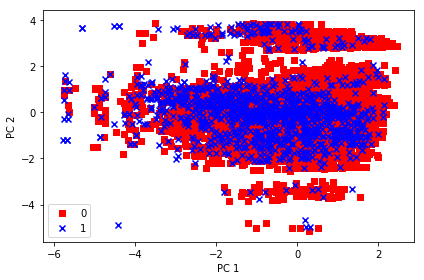

In [37]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b']
markers = ['s', 'x']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()


In [38]:
X_train_std[0].dot(w)

array([ 1.49465289, -0.27957024])

# PCA (scikit)

In [39]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.2073469 , 0.17504597, 0.12699645, 0.10734253, 0.08752426,
       0.08353437, 0.07669872, 0.07273894, 0.06277185])

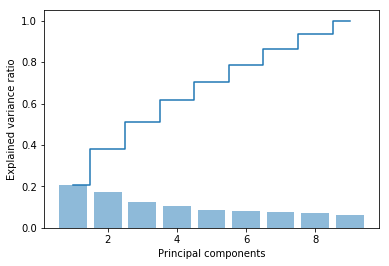

In [42]:
plt.bar(range(1, 10), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 10), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [43]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

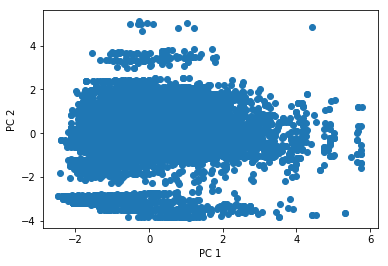

In [44]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [45]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

In [46]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)

/Users/antonio/anaconda2/envs/dropout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


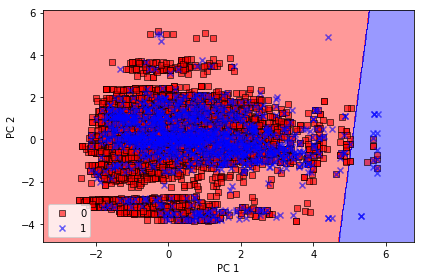

In [47]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca3.png', dpi=300)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


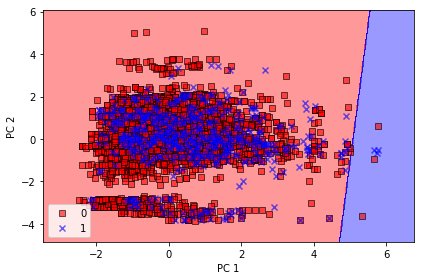

In [48]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca4.png', dpi=300)
plt.show()

In [49]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.2073469 , 0.17504597, 0.12699645, 0.10734253, 0.08752426,
       0.08353437, 0.07669872, 0.07273894, 0.06277185])

# LDA

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [51]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda3.png', dpi=300)
plt.show()

/Users/antonio/anaconda2/envs/dropout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


IndexError: index 1 is out of bounds for axis 1 with size 1

In [52]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda4.png', dpi=300)
plt.show()


IndexError: index 1 is out of bounds for axis 1 with size 1

## KPCA (scikit)

In [53]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from numpy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.linalg.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)

    # Collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack((eigvecs[:, -i]
                            for i in range(1, n_components + 1)))

    return X_pc

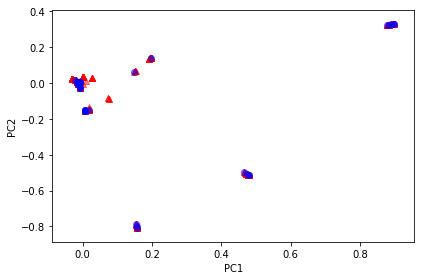

In [67]:
from sklearn.decomposition import KernelPCA

#X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X_train_std)

plt.scatter(X_skernpca[y_train == 0, 0], X_skernpca[y_train == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y_train == 1, 0], X_skernpca[y_train == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
# plt.savefig('./figures/scikit_kpca.png', dpi=300)
plt.show()